### Objective
The challenge involves generating realistic dog images using generative deep learning models. The objective is to train a model that can learn the underlying distribution of real dog images and synthesize new, high-quality images that are visually convincing. This task falls under the domain of generative modeling, with models like Generative Adversarial Networks (GANs) commonly used due to their ability to learn complex data distributions. The Stanford Dogs Dataset consists of approximately 12,000 color images of dogs, organized into subdirectories by breed. Each image is in JPG format, with varying dimensions and aspect ratios, though they are typically resized and center-cropped to 64×64×3 for model training. The dataset has no associated labels, making it suitable for unsupervised generative tasks. [Link to Images](http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar)

Google GPU resources has been utilized to train the model. training multiple iterations costed about 100 units.

[GitHub Repo](https://github.com/Bilal1k/Dog-Gen)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import glob
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR



In [ ]:
dogPath= '/content/drive/DTSA 5511/all-dogs-flat'
checkpoint_path = "/content/drive/DTSA 5511/dogModel/gan_checkpoint.pth"


In [ ]:
# Dataset Preparation

class DogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        print("Received root_dir:", root_dir)
        self.paths = sorted(glob.glob(os.path.join(root_dir, '*.jpg')))
        print("Found images:", len(self.paths))
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # [-1, 1] range
])

# Loader
dataset = DogDataset(root_dir=dogPath, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

Received root_dir: /content/drive/Othercomputers/XPS/Documents/Learning/ColoradoMSDS/DTSA 5511_2/all-dogs-flat
Found images: 41160


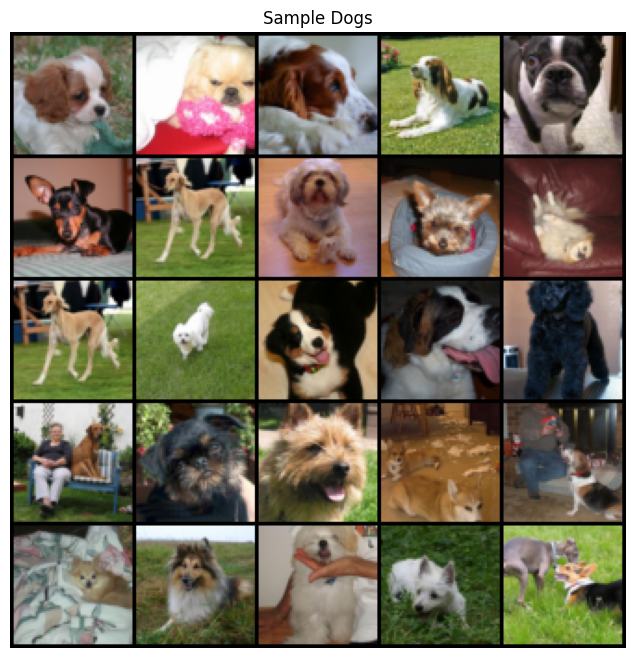

In [ ]:
# Visualizing Sample Images
def visualaize(dataset, num_images=25):
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    data_iter = iter(loader)
    images = next(data_iter)
    grid = utils.make_grid(images, nrow=5, normalize=True)
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    plt.title("Sample Dogs")
    plt.show()

visualaize(dataset)


### Modelling (DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS)
Due to time and computational resource limitation, we will use a pure GAN approach (No latent feature encoder to start from). Our generator will start fro a scratch (donsn't know anything about dogs), a random noise vector. It will up-sample (the opposite of simplifying in CNN) until this random noise vector becomes a high definition image.

Generator Design:
-   The generator starts with a random noise vector of size 100, represented as a 1×1 pixel with 100 channels. This serves as the input latent code.

-   The first layer applies a transposed convolution to expand this input from [100 channels, 1 height, 1 width] to [512 channels, 4 height, 4 width]. This builds a spatial grid from the latent vector. Full credit to Thom Lane in his [Medium article: Transposed Convolutions explained with… MS Excel!](https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8), which provides helpful visualizations:

![image.png](https://miro.medium.com/v2/resize:fit:720/format:webp/1*kOThnLR8Fge_AJcHrkR3dg.gif)

A numerical example from the same source:

![image.png](https://miro.medium.com/v2/resize:fit:720/format:webp/1*P1ERo2i1mbMeB1LkPQ4crA.png)

-   After each transposed convolution, we apply batch normalization to stabilize training and normalize activations across the batch, followed by a ReLU activation to introduce non-linearity.

-   This pattern of upsampling to normalization to activation is repeated across multiple layers, where the number of channels is gradually reduced and the spatial resolution increased.

-   The final output layer produces a 64×64 RGB image with 3 channels using a transposed convolution followed by a Tanh activation, which maps the pixel values to the range [-1, 1] to match the normalized training data.


Discriminator Design:

-   The Discriminator takes an RGB image of size 64×64×3 as input and outputs a single probability value indicating whether the image is real (from the dataset) or fake (from the generator).

-   The architecture consists of a series of convolutional layers that progressively downsample the image and extract  abstract features, ultimately reducing the input to a 1×1 score.

- Layer 1: Feature Extraction and Initial Downsampling uses a leakyReLU activation to allow minor gradient flow for negative values (helps prevent dying neurons).

- Layers 2–4: Deeper Feature Extraction:
    -   Doubles the number of channels on each layer.
    -   Halves the spatial resolution on each layer.
    -   Uses BatchNorm to stabilize training.
    -   Applies LeakyReLU for non-linearity

-   Final Layer: Classification:
    -   Reduces [B, 512, 4, 4] to [B, 1, 1, 1]


References:
-   [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks
by Alec Radford, Luke Metz, Soumith Chintala](https://arxiv.org/pdf/1511.06434)

-   [Medium article: Transposed Convolutions explained with… MS Excel! by Thom Lane](https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8)
    

In [9]:
# DCGAN Model Definition
class Generator(nn.Module):
    def __init__(self, latent_dim=100, channels=64):
        super().__init__()
        self.main = nn.Sequential(
            # Input: [B, latent_dim, 1, 1]
            nn.ConvTranspose2d(
                in_channels=latent_dim,     # typically 10 or 100 (size of the noise vector)
                out_channels=channels * 8,  # 512 channels if channels start at 64
                kernel_size=4,              # 4×4 Convulsion Transpose filter, reverse of CNN convolution.
                 stride=1,                  # no stride; upsample 1 to 4
                padding=0,                  # no padding; clean upsample
                bias=False                  # no bias (since followed by BatchNorm)
            ),  # output [B, 512, 4, 4]

            nn.BatchNorm2d(num_features=channels * 8),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(
                in_channels=channels * 8,
                out_channels=channels * 4,  # 256
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),  # output [B, 256, 8, 8]

            nn.BatchNorm2d(num_features=channels * 4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(
                in_channels=channels * 4,
                out_channels=channels * 2,  # 128
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),  # output [B, 128, 16, 16]

            nn.BatchNorm2d(num_features=channels * 2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(
                in_channels=channels * 2,
                out_channels=channels,  # 64
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),  # output [B, 64, 32, 32]

            nn.BatchNorm2d(num_features=channels),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(
                in_channels=channels,
                out_channels=3,  # RGB image
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),  # output [B, 3, 64, 64]

            nn.Tanh()  # scale output to [-1, 1] range
        )

    def forward(self, x):
        return self.main(x)


    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, ndf=64):
        super().__init__()
        self.main = nn.Sequential(
            # Input: [B, 3, 64, 64] RGB image

            nn.Conv2d(
                in_channels=3,         # RGB image has 3 channels
                out_channels=ndf,      # number of filters in first layer (e.g., 64)
                kernel_size=4,         # 4x4 convolutional filter
                stride=2,              # downsample by factor of 2 (64 to 32)
                padding=1,             # maintain spatial alignment
                bias=False             # no bias (BatchNorm handles shift)
            ),  # output [B, 64, 32, 32]
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(
                in_channels=ndf,
                out_channels=ndf * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),  # output [B, 128, 16, 16]
            nn.BatchNorm2d(num_features=ndf * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(
                in_channels=ndf * 2,
                out_channels=ndf * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),  # output [B, 256, 8, 8]
            nn.BatchNorm2d(num_features=ndf * 4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(
                in_channels=ndf * 4,
                out_channels=ndf * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),  # output [B, 512, 4, 4]
            nn.BatchNorm2d(num_features=ndf * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(
                in_channels=ndf * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            )  # output [B, 1, 1, 1]
        )

    def forward(self, x):
        return self.main(x).view(-1)



### Training Loop

The training loop alternates between training the Discriminator (D) and the Generator (G) using adversarial learning. The objective is for the discriminator to distinguish real from fake images, while the generator learns to produce fake images that the discriminator believes are real.
Steps for each epoch:
-   Train the Discriminator (D):Maximize probability of assigning the correct label (real or fake)
-   Train the Generator (G)
-   Visualization images to capture improvement over time

Loaded checkpoint, resuming from epoch 100
Epoch [100/101] Batch [0/322] Loss_D: 0.7662 Loss_G: 2.7364
LR_G: 0.000300 | LR_D: 0.000300
Epoch [100/101] Batch [100/322] Loss_D: 0.9805 Loss_G: 3.1605
LR_G: 0.000300 | LR_D: 0.000300
Epoch [100/101] Batch [200/322] Loss_D: 0.9102 Loss_G: 1.0648
LR_G: 0.000300 | LR_D: 0.000300
Epoch [100/101] Batch [300/322] Loss_D: 0.8222 Loss_G: 2.5026
LR_G: 0.000300 | LR_D: 0.000300


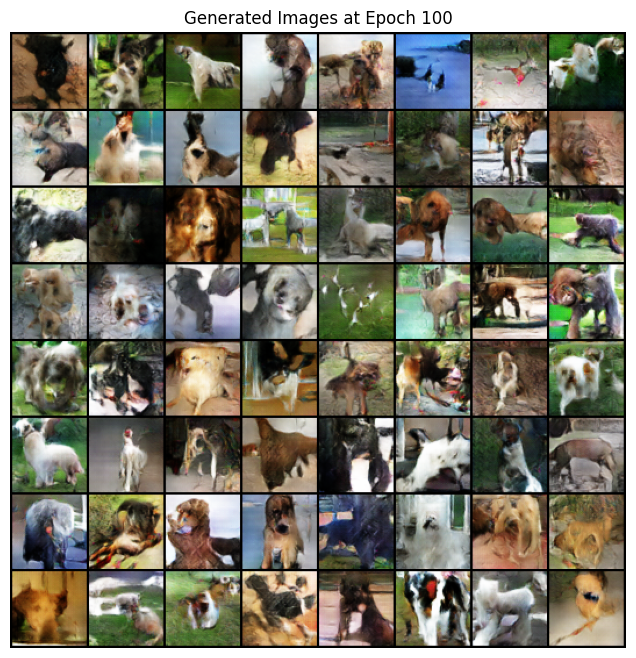

In [11]:
# Use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models and move to device
G = Generator().to(device)
D = Discriminator().to(device)

# Initialize weights as recommended in DCGAN paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G.apply(weights_init)
D.apply(weights_init)

# Binary cross-entropy loss with logits (removed Sigmoid from Discriminator)
criterion = nn.BCEWithLogitsLoss()

# Optimizers for generator and discriminator (Adaptive Moment Estimation)
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0003, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0003, betas=(0.5, 0.999))

# Learning rate rise and fall cyclically, helping escape plateaus
schedulerG = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerG, T_max=10, eta_min=1e-5)
schedulerD = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerD, T_max=10, eta_min=1e-5)


# Load previous checkpoint if available
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    G.load_state_dict(checkpoint['generator_state_dict'])
    D.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
    optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Loaded checkpoint, resuming from epoch {start_epoch}")

# Settings
latent_dim = 100  # size of the input noise vector
flip_prob = 0.05  # label flip probability (5%) (added to avoid platue point and make the discrminator less confident)
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)  # fixed seed for image snapshots

# For tracking losses
G_losses = []
D_losses = []

epochs = 101  # total number of training epochs

for epoch in range(start_epoch, epochs):
    for i, real_images in enumerate(dataloader):
        b_size = real_images.size(0)
        real_images = real_images.to(device)

        # TRAIN DISCRIMINATOR
        D.zero_grad()

        # Create smoothed real labels (1 → 0.9) and flip some to fake (0.0)
        real_labels = torch.full((b_size,), 0.9, dtype=torch.float, device=device)
        flip_real_mask = torch.rand(b_size, device=device) < flip_prob
        real_labels[flip_real_mask] = 0.0

        output = D(real_images)
        loss_real = criterion(output, real_labels)
        loss_real.backward()

        # Generate fake images from noise
        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        fake_images = G(noise)

        # Create fake labels (0.0), and flip some to real (1.0)
        fake_labels = torch.full((b_size,), 0.0, dtype=torch.float, device=device)
        flip_fake_mask = torch.rand(b_size, device=device) < flip_prob
        fake_labels[flip_fake_mask] = 1.0

        output = D(fake_images.detach())
        loss_fake = criterion(output, fake_labels)
        loss_fake.backward()

        optimizerD.step()

        # TRAIN GENERATOR
        G.zero_grad()

        # Generator tries to fool discriminator: wants D(fake) → 1.0
        gen_labels = torch.full((b_size,), 1.0, dtype=torch.float, device=device)
        output = D(fake_images)
        lossG = criterion(output, gen_labels)
        lossG.backward()

        optimizerG.step()

        # Logging
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch [{i}/{len(dataloader)}] "
                  f"Loss_D: {loss_real + loss_fake:.4f} Loss_G: {lossG:.4f}")
            print(f"LR_G: {schedulerG.get_last_lr()[0]:.6f} | LR_D: {schedulerD.get_last_lr()[0]:.6f}")

        # Track loss for plotting later
        G_losses.append(lossG.item())
        D_losses.append(loss_real.item() + loss_fake.item())

    # Save model and optimizer states
    torch.save({
        'epoch': epoch,
        'generator_state_dict': G.state_dict(),
        'discriminator_state_dict': D.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
    }, checkpoint_path)

    # Step learning rate schedulers
    schedulerG.step()
    schedulerD.step()

    # VISUALIZE PROGRESS
    with torch.no_grad():
        fake = G(fixed_noise).detach().cpu()
        grid = utils.make_grid(fake, nrow=8, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.title(f"Generated Images at Epoch {epoch}")
        plt.axis("off")
        plt.show()


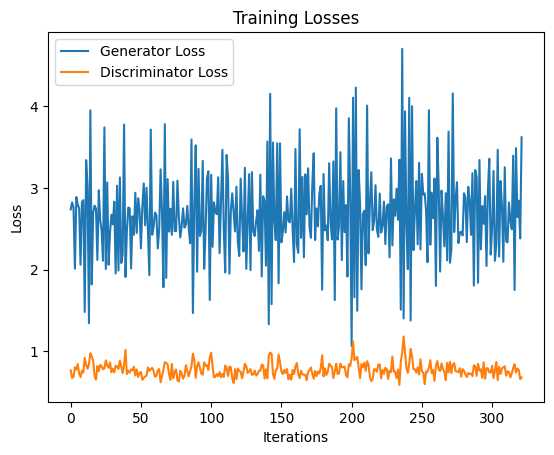

In [12]:
import matplotlib.pyplot as plt

plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Losses")
plt.show()

In [ ]:
# Save Generated Images
output_folder = '/content/drive/DTSA 5511/genDogs'
os.makedirs(output_folder, exist_ok=True)

G.eval()
with torch.no_grad():
    for i in range(20):
        z = torch.randn(1, 100, 1, 1).to(device)
        fake = G(z)
        vutils.save_image(fake, os.path.join(output_folder, f"{i:05d}.png"), normalize=True)


### Conclusion

This project attempted to implemented a Deep Convolutional GAN (DCGAN) to generate realistic dog images using the Stanford Dogs Dataset (from Stanford). By progressively training the generator and discriminator with adversarial feedback, we were able to synthesize what on the first glance might look like visually plausible images, with improvements observed through visual inspection and stabilized loss metrics. There is still a lot room for improvements

Key techniques like label smoothing, learning rate scheduling, and label flipping were incorporated to address training instability and mode collapse—common challenges in GAN training. Despite computational constraints, the model showed meaningful learning progress up to a saturation point around the 20th epoch.

### Future Work

To further improve image quality and model robustness, the following steps are proposed:

- Use pre-trained encoders (e.g., VGG or Inception) instead of a random noise vector to guide generator learning via perceptual loss.

- Implement progressive growing GANs (PGGAN) for higher resolution image synthesis.

With additional compute resources (e.g., sustained access to A100 GPUs), these enhancements could further push the quality of generated content and enable experimentation with more advanced GAN variants.